In [1]:
import sys
import os

try:
    import synthnoise.noise as synth_noise
    import synthnoise.eis_models as eis_models
except ImportError:
    sys.path.append(os.path.abspath('..'))
    import synthnoise.noise as synth_noise
    import synthnoise.eis_models as eis_models


In [2]:
%matplotlib inline

In [3]:
import numpy as np
import scipy.signal as signal
import scipy.fft as spfft
import matplotlib.pyplot as plt

In [4]:
plt.rcParams['figure.dpi'] = 100

## Synthesizing a random series from a known power spectrum

These examples use the Kolmogorov spectral factorization method to take a thermal noise power spectrum and create synthetic noise voltages.

Spectral factorization code based on http://web.cvxr.com/cvx/examples/filter_design/html/spectral_fact.html

## Basic EIS compartments

This simple electrode model is currently supported:

```


        |``CPE``|
   Buf--|       |--Rs---[Gnd elec]
        ----R----
        
```

* Parallel electrode comparments: constant phase element (CPE) and faradaic R
* Tissue compartments: R series

The real electrode resistor is required here to ensure a finite DC value for the EIS. To make the CPE a pure capacitor, use "alpha=1".

### Default EIS model based on packaged data

The default parameters are fit from the average EIS from µECoG channels.

In [5]:
reload(eis_models)

<module 'synthnoise.eis_models' from '/Users/mike/work/misc_code/synth_thermal_noise/synthnoise/eis_models.py'>

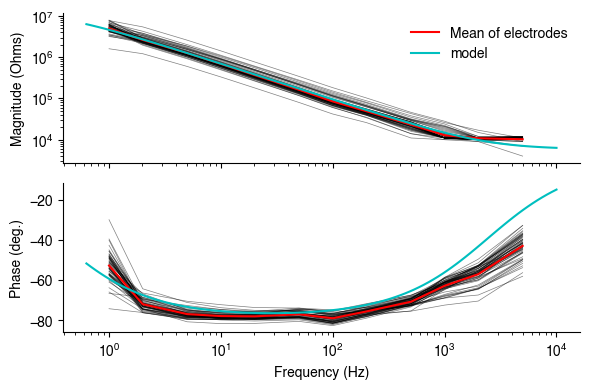

In [6]:
model, eis, f = eis_models.show_fit_eis()

In [7]:
model

{'alpha': 0.8746120417896207,
 'Ck': 3.787473863663546e-08,
 'Rct': 13721959.398432864,
 'Rs': 5799.763529719425}

### Fitting any EIS

You can fit this electrode model (curently only this model) to other EIS measurements using ``fit_eis``. I'll use the packaged data to demonstrate.

In [8]:
dat_path = os.path.join('..', 'synthnoise', 'eis_data.npz')
z = np.load(dat_path)
eis_f = z['eis_f']
eis_m = z['eis_m']
eis_p = z['eis_p']

Only fit one spectrum at a time. Use either magnitude & phase:

In [9]:
model, data = eis_models.fit_eis(eis_f, eis_m=eis_m[0], eis_p=eis_p[0])
model

{'alpha': 0.8194452720952342,
 'Ck': 2.999706958206811e-08,
 'Rct': 38757765.02073651,
 'Rs': 3403.0785534353204}

Or use complex impedance (``eis_z=``)

In [10]:
model, data = eis_models.fit_eis(eis_f, eis_z=eis_m[0] * np.exp(1j * np.pi * eis_p[0] / 180))
model

{'alpha': 0.8194452720952342,
 'Ck': 2.999706958206811e-08,
 'Rct': 38757765.02073651,
 'Rs': 3403.0785534353204}

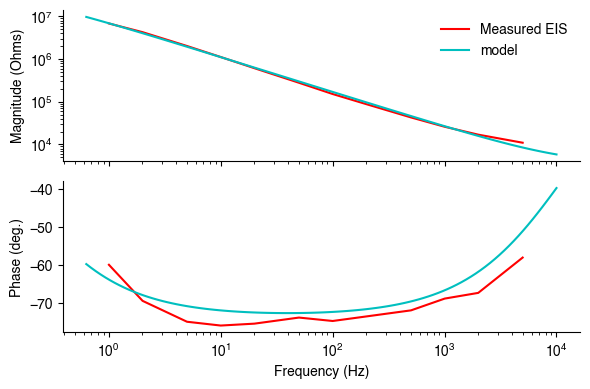

In [11]:
f = eis_models.show_fit_eis(eis_data=data, model=model)[2]

### Thermal noise spectra

Noise synthesis is based on the thermal noise spectrum (proportional to the real part of the EIS).

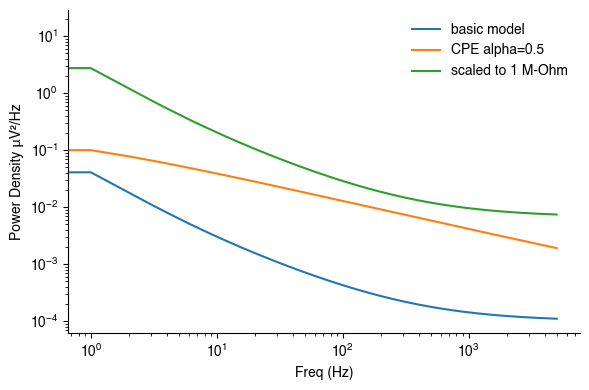

In [12]:
freqs = np.linspace(0, 5000, 5001)
# The stocked parameters from above are used by default
tnoise_spectrum = eis_models.thermal_noise(freqs)
# Any/all of the parameters can be changed
tnoise_spectrum_2 = eis_models.thermal_noise(freqs, alpha=0.5)
# Alternately, the model can be scaled to pass a given magnitude impedance value at 1 kHz
tnoise_spectrum_3 = eis_models.thermal_noise(freqs, scaleto=1e6)
f, ax = plt.subplots()
ax.loglog(freqs, tnoise_spectrum, label='basic model')
ax.loglog(freqs, tnoise_spectrum_2, label='CPE alpha=0.5')
ax.loglog(freqs, tnoise_spectrum_3, label='scaled to 1 M-Ohm')
ax.legend()
ax.set_xlabel('Freq (Hz)')
ax.set_ylabel(u'Power Density \u03BCV\u00B2/Hz')
f.tight_layout()

## Noise synthesis

Call simulate_thermal_noise. **Use debug mode to see the model noise spectrum and filter settings.**

* seq length: 32768 points
* sequence bandwidth: 20000 Hz
* simulate 10 channels
* scaleto: scale the EIS spectrum to pass through 500 k-Ohms at f=1000 Hz
* bandpass: do 0.1 - 7500 Hz to match the Intan RHD onboard filtering

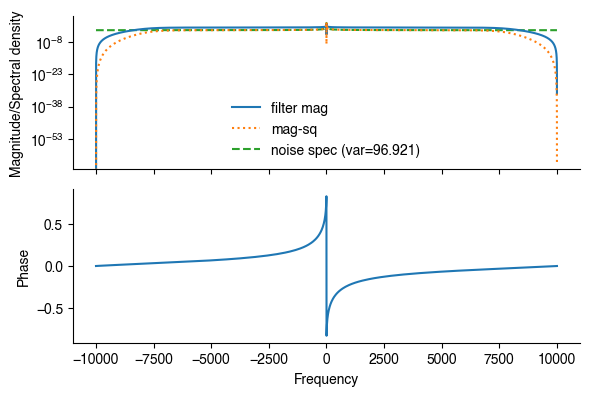

In [13]:
nz_seq = synth_noise.simulate_thermal_noise(2 ** 15, 20000, n_chan=10, debug=True, 
                                            scaleto=500e3, bandpass=(0.1, 7500))

The actual variance is slightly lower than the full bandwidth variance, due to the 7500 Hz lowpass filter.

In [14]:
nz_seq.var(1).mean(), nz_seq.var(1).std()

(72.58916404909652, 4.320419112829834)

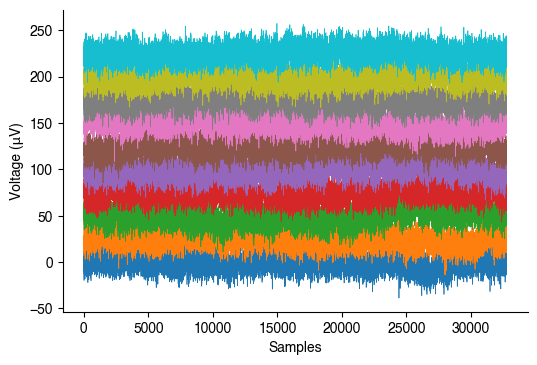

In [15]:
plt.figure()
_ = plt.plot(nz_seq.T + np.arange(10) * 25, lw=0.5)
_ = plt.xlabel('Samples')
_ = plt.ylabel(u'Voltage (\u03BCV)')

## Confirm PSD consistency

Do a quick multitaper PSD

In [16]:
def quick_psd(x, bw, NW=3):
    n = x.shape[-1]
    dpss_win = signal.windows.dpss(n, NW, Kmax=int(2 * NW) - 1, sym=False, norm=2)
    yk = spfft.fft(x * dpss_win)
    fxx = np.linspace(0, 0.5, n // 2 + 1) * bw
    yk = np.abs(yk[..., :n // 2 + 1]) ** 2
    # Basic MT estimator and SD confidence intervals
    pxx = np.exp(np.mean(np.log(yk), axis=0))
    pxx_ci = np.std(np.log(yk), axis=0)
    # This is exp(mu +/- sd)
    pxx_ci = np.array([pxx / pxx_ci, pxx * pxx_ci])
    # Normalize PSD to power / Hz
    pxx /= fxx[-1]
    pxx_ci /= fxx[-1]
    return fxx, pxx, pxx_ci


bw = 2e4  # Bandwidth
fxx, pxx, pxx_ci = quick_psd(nz_seq[0], bw)

And compute the model spectrum

In [17]:
tnoise_model = eis_models.thermal_noise(fxx, scaleto=500e3)

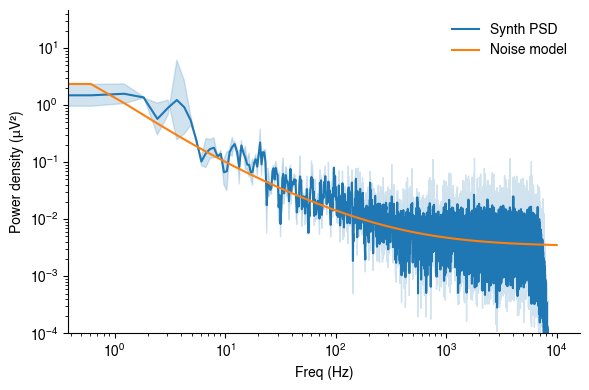

In [18]:
f, ax = plt.subplots()
ax.loglog(fxx, pxx, label='Synth PSD')
# ax.loglog(fxx, pxx_ci.T, color='r', ls=':', lw=0.2)
ax.loglog(fxx, tnoise_model, label='Noise model')
ax.fill_between(fxx, y1=pxx_ci[0], y2=pxx_ci[1], color='tab:blue', alpha=0.2, zorder=-10)
ax.set_ylim(bottom=1e-4)
ax.legend()
ax.set_xlabel('Freq (Hz)')
ax.set_ylabel(u'Power density (\u03BCV\u00B2)')
f.tight_layout()

## Synthesizing longer series and/or higher sampling resolution

A blockwise method can be used for synthesizing big series, or for synthesizing full rate (e.g. 20 kHz) series that will be downsampled.

Parameters:

* Synthesize 2 minutes
* Final sampling rate 2 kHz (resampled from 20 kHz)
* 10 channels
* 0.1 - 300 Hz bandpass (arbitrary)
* specific electrode compartment model parameters (kind of arbitrarily chosen)

In [19]:
full_bw = 2e4
resample_bw = 2e3
pts = int(2 * 60 * resample_bw)
chans = 10
params=dict(Ck=5e-10, Rs=10e3, Rct=100e6)

noise = synth_noise.long_noise_series(pts, full_bw, chans, (0.1, 300), 
                                      resample_bw=resample_bw,
                                      **params)

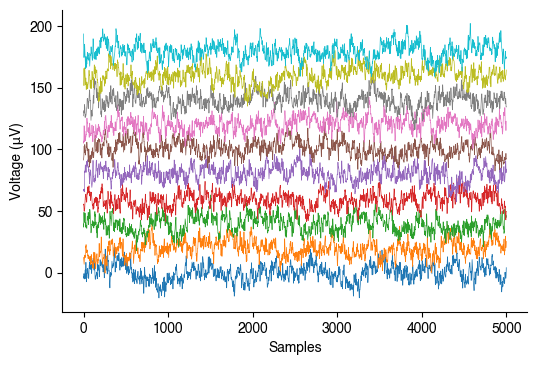

In [20]:
plt.figure()
_ = plt.plot(noise[:, :5000].T + np.arange(chans) * 20, lw=0.5)
_ = plt.xlabel('Samples')
_ = plt.ylabel(u'Voltage (\u03BCV)')

In [21]:
bw = 2e3  # Bandwidth
fxx, pxx, pxx_ci = quick_psd(noise[0], bw)

In [22]:
tnoise_model = eis_models.thermal_noise(fxx, **params)

Confirm the noise series PSD with the model. Note that the noise series has the correct 0.1 - 300 Hz bandpass.

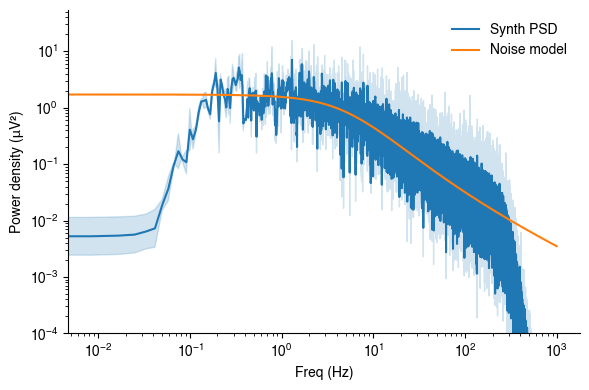

In [23]:
f, ax = plt.subplots()
ax.loglog(fxx, pxx, label='Synth PSD')
# ax.loglog(fxx, pxx_ci.T, color='r', ls=':', lw=0.2)
ax.loglog(fxx, tnoise_model, label='Noise model')
ax.fill_between(fxx, y1=pxx_ci[0], y2=pxx_ci[1], color='tab:blue', alpha=0.2, zorder=-10)
ax.set_ylim(bottom=1e-4)
ax.legend()
ax.set_xlabel('Freq (Hz)')
ax.set_ylabel(u'Power density (\u03BCV\u00B2)')
f.tight_layout()